# Functions

In [1]:
import astropy.units as u
import sunpy.map
from astropy.coordinates import SkyCoord
import matplotlib
from sunpy.coordinates import Helioprojective
import matplotlib.pyplot as plt
from sunpy.sun import constants
from matplotlib.colors import LogNorm

def find_maxima_STIX(map,threshold):
    from cmath import nan
    import numpy as np
    import scipy
    import scipy.ndimage as ndimage
    import scipy.ndimage.filters as filters
    import matplotlib.pyplot as plt
    import astropy.units as u

    data = map.data
    data = np.where(np.isnan(data),-np.inf,data)

    neighborhood_size = 8
    threshold = np.nanmax(data)*threshold

    data_max = ndimage.maximum_filter(data, neighborhood_size)
    maxima = (data == data_max)
    diff = (data_max > threshold)
    maxima[diff == 0] = 0

    labeled, num_objects = ndimage.label(maxima)
    slices =ndimage.find_objects(labeled)
    points = []
    for dy,dx in slices:
        x_center = (dx.start + dx.stop -1)/2
        y_center = (dy.start + dy.stop -1)/2
        points.append(map.pixel_to_world(x_center*u.pixel,y_center*u.pixel))
    return(points)

def get_blank_map(ori_map):
    import sunpy.map
    import numpy as np
    import copy
    data = np.ones_like(copy.deepcopy(ori_map).data)
    header = copy.deepcopy(ori_map).meta
    blank_map = sunpy.map.Map(data, header)
    return blank_map

def Set_wlim(ax,map,wx,wy):
    from astropy.coordinates import SkyCoord
    px=map.world_to_pixel(SkyCoord(wx,wy,frame=map.coordinate_frame)).x.value
    py=map.world_to_pixel(SkyCoord(wx,wy,frame=map.coordinate_frame)).y.value
    ax.set_xlim(px)
    ax.set_ylim(py)


## --- Key functions

#Project a point in AIA to STIX's view when the point is actually at the back side of the disk in STIX.
def Project_to_back(map_back,point):
    from sunpy.coordinates import Helioprojective

    obs_back=map_back.coordinate_frame.observer
    obs_back_r = SkyCoord(
        lon=obs_back.lon+180*u.degree,
        lat=-obs_back.lat,
        radius=obs_back.radius,
        obstime=obs_back.obstime,
        rsun=obs_back.rsun,
        frame="heliographic_stonyhurst"
    )
    map_frame_back=map_back.coordinate_frame

    map_frame_back_r = Helioprojective(
        obstime=map_frame_back.obstime,
        rsun=map_frame_back.rsun,
        observer=obs_back_r
    )
    pro_point0=point.transform_to(map_frame_back_r)

    pro_point = SkyCoord(
        Tx=-pro_point0.Tx,
        Ty=pro_point0.Ty,
        obstime=pro_point0.obstime,
        observer=obs_back,
        rsun=pro_point0.rsun,
        frame="helioprojective"
    )

    return pro_point

#Estimate height of a point: h=l_point-l_base. l is the radial distance from the point to the disk center
def Get_ht(point,base_point,rsun_arc,rsun_ref):
    from numpy import linalg as LA
    import numpy as np
    ht=np.average([((LA.norm([point.Tx.value,point.Ty.value])
                -LA.norm([bp.Tx.value,bp.Ty.value]))
                /rsun_arc*rsun_ref*u.m).to(u.Mm).value 
                for bp in base_point])
    return ht

#Update the SkyCoord info (coordinates) of a point
def update_ht_in_coord(pos_ori,ht):
    from astropy.coordinates import SkyCoord
    ## update the info of observer
    observer=pos_ori.observer

    new_observer_coord = SkyCoord(
        lon=observer.lon+180*u.degree,
        lat=-observer.lat,
        radius=observer.radius,
        obstime=observer.obstime,
        rsun=observer.rsun+(ht*u.Mm),
        frame="heliographic_stonyhurst"
    )
    ## update the info of coordinate
    pos_upd = SkyCoord(
        Tx=-pos_ori.Tx,
        Ty=pos_ori.Ty,
        obstime=pos_ori.obstime,
        #observer=pos_ori.observer,
        observer=new_observer_coord,
        rsun=pos_ori.rsun+(ht*u.Mm),
        frame="helioprojective"
    )
    return pos_upd

#For better plotting the transformed contour
def Transform_coord_to_one_map(coord_list,coord_frame):
    from astropy.coordinates import SkyCoord
    tramsformed_coord=[c.transform_to(coord_frame) for c in coord_list]
    Tx_list = [coord.Tx.value for coord in tramsformed_coord]
    Ty_list = [coord.Ty.value for coord in tramsformed_coord]
    skycoord_list = SkyCoord(Tx_list*u.arcsec, Ty_list*u.arcsec, frame=coord_frame)
    return skycoord_list



# Read maps

In [ ]:
aia_fn=[aia_dir+"aia.lev1_euv_12s.2023-09-28T090632Z.131.image_lev1.fits",
        aia_dir+"aia.lev1_uv_24s.2023-09-28T090640Z.1600.image_lev1.fits"]

stix_fn=[stix_dir+"stix_L3A_quicklook_20230928T085915-20230928T090215_25-50keV_2309285283_41913_clean_hpc.fits"]

In [2]:
xarc=[-1100,-700]*u.arcsec
yarc=[-600,-200]*u.arcsec
aia_maps0=sunpy.map.Map(aia_fn)
aia_maps=[m.submap(SkyCoord(xarc,yarc,frame=m.coordinate_frame)) for m in aia_maps0]

cmapgrey = matplotlib.colormaps['Greys_r']
cmapgrey.set_bad('black')

cmap131 = matplotlib.colormaps['sdoaia131']
cmap131.set_bad('black')
norm131=LogNorm(vmin=2,vmax=1.8e4)

cmap1600 = matplotlib.colormaps['sdoaia1600']
cmap1600.set_bad('black')
norm1600=LogNorm(vmin=2,vmax=1.1e4)

In [3]:
stix_shift=[0*u.arcsec,0*u.arcsec]
stix_maps0=sunpy.map.Map(stix_fn)
stix_maps1=[m.shift_reference_coord(stix_shift[0],stix_shift[1]) for m in stix_maps0]
stix_maps=stix_maps1
blank_map=get_blank_map(stix_maps[0])

# Large field of view

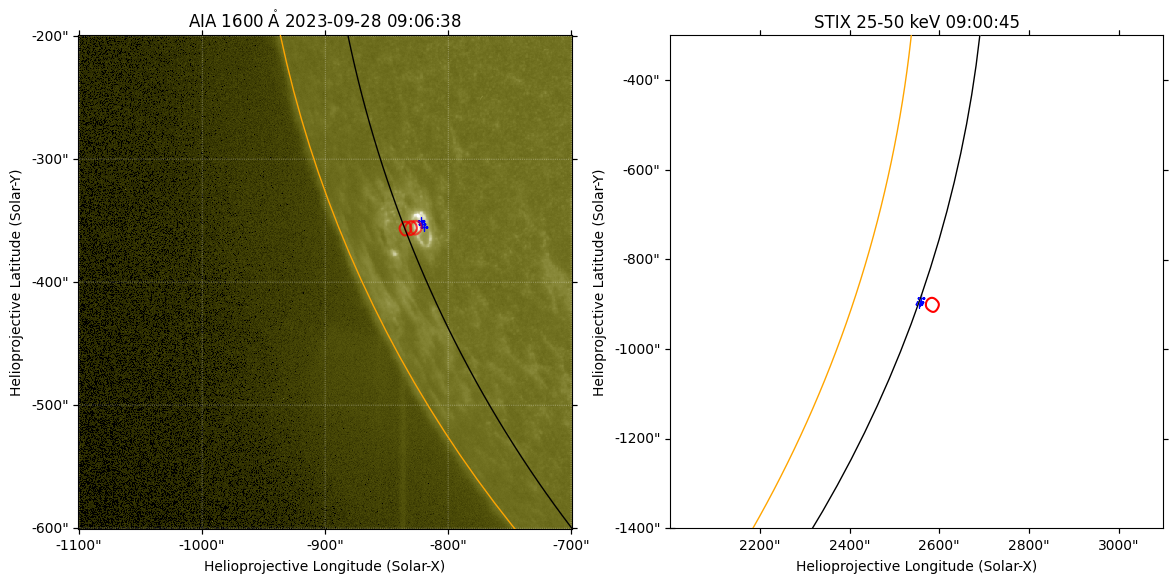

In [9]:
aia_map=aia_maps[1]
stix_map=stix_maps[0]

base_points=[SkyCoord(Tx=-822*u.arcsec,Ty=-350*u.arcsec, frame=aia_map.coordinate_frame),
             SkyCoord(Tx=-821*u.arcsec,Ty=-353*u.arcsec, frame=aia_map.coordinate_frame),
             SkyCoord(Tx=-820*u.arcsec,Ty=-355*u.arcsec, frame=aia_map.coordinate_frame)]
pro_base_point=[Project_to_back(stix_map,bp) for bp in base_points] #Project the base points to the STIX's view
#base_points,pro_base_point
linewidths=0.6
aia_color='orange'
stix_color='black'
base_color='blue'
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate,only_off_disk=True):

    fig=plt.figure(figsize=(14,7))
    plt.rc('font', size=10)

    ax1=fig.add_subplot(1,2,1,projection=aia_map)
    aia_map.plot(axes=ax1,norm=norm1600,cmap=cmap1600)
    aia_map.draw_limb(axes=ax1,color=aia_color,linestyle='solid')
    stix_map.draw_limb(axes=ax1,color=stix_color,linestyle='solid')

    for bp in base_points:
        ax1.plot_coord(bp,'+',color=base_color) #plot base points in AIA's view


    ax2=fig.add_subplot(1,2,2,projection=blank_map)
    blank_map.plot(axes=ax2,cmap='Greys')
    blank_map.draw_limb(axes=ax2)
    ax2.set_title('STIX 25-50 keV '+blank_map.meta['date-avg'][11:19])
    stix_map.draw_limb(axes=ax2,color=stix_color)
    aia_map.draw_limb(axes=ax2,color=aia_color,linestyle='solid')

    xarc = [2000,3100] * u.arcsec
    yarc = [-1400,-300] * u.arcsec
    Set_wlim(ax2,blank_map,xarc,yarc) #Set field of view

    maxv=stix_map.data.max()
    levels=[0.5*maxv]
    stix_map.draw_contours(axes=ax2,levels=levels,colors='red')

    for bp in pro_base_point:
        ax2.plot_coord(bp,'+',color=base_color) #plot base points in STIX's view

    ## --- project the contour in STIX to AIA's view
    rsun_arc=stix_map.meta['rsun_arc'] #r_sun in arcsecond
    rsun_ref=stix_map.meta['rsun_ref'] #r_sun in Mm
    maxv=stix_map.data.max()
    levels=[0.5*maxv]
    cont_coord_list=[stix_map.contour(l)for l in levels] #get the position of every pixel of contour
    coord_frame=aia_map.coordinate_frame
    color='red'

    for cont_coord in cont_coord_list:
        for cc in cont_coord:
            cc_list=[SkyCoord(cc.Tx[i],cc.Ty[i],frame=cc.frame) for i in range(len(cc.Tx))]
            hts=[Get_ht(cl,pro_base_point,rsun_arc,rsun_ref) for cl in cc_list] #get estimated height of every pixel

            cc_list_upd=[update_ht_in_coord(cl,ht+0.18) for cl,ht in zip(cc_list,hts)] #update the SkyCoord info of every pixel
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame) #prepare for plotting the transformed contour
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.8) #plot the contour
            
            cc_list_upd=[update_ht_in_coord(cl,ht+0.3) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.8)

            cc_list_upd=[update_ht_in_coord(cl,ht+0.5) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.6)
            

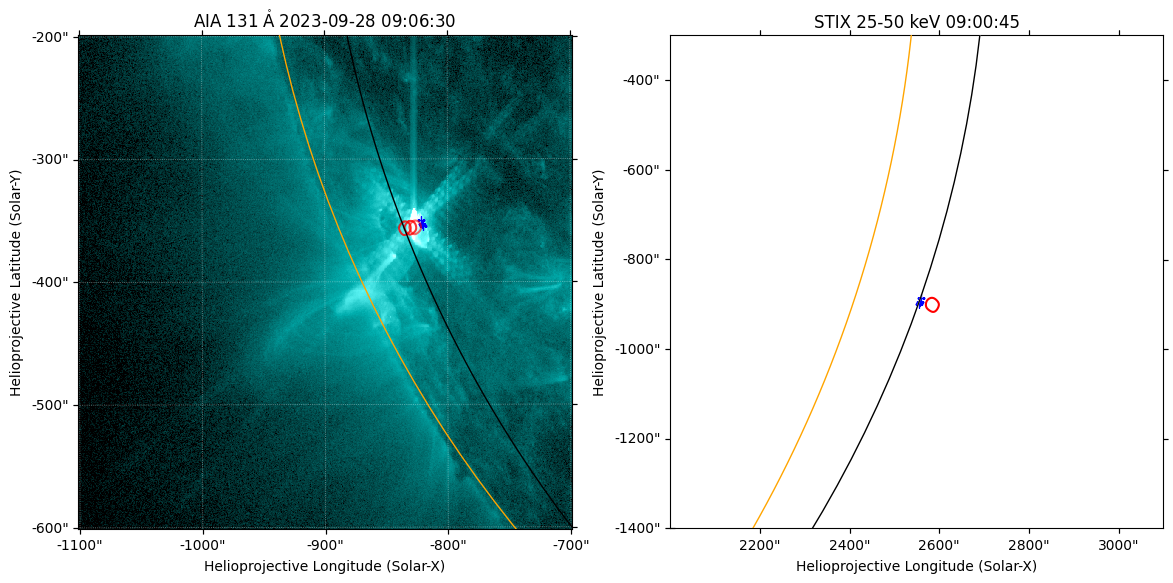

In [6]:
aia_map=aia_maps[0]
stix_map=stix_maps[0]

base_points=[SkyCoord(Tx=-822*u.arcsec,Ty=-350*u.arcsec, frame=aia_map.coordinate_frame),
             SkyCoord(Tx=-821*u.arcsec,Ty=-353*u.arcsec, frame=aia_map.coordinate_frame),
             SkyCoord(Tx=-820*u.arcsec,Ty=-355*u.arcsec, frame=aia_map.coordinate_frame)]
pro_base_point=[Project_to_back(stix_map,bp) for bp in base_points]
#base_points,pro_base_point
linewidths=0.6
aia_color='orange'
stix_color='black'
base_color='blue'
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate,only_off_disk=True):

    fig=plt.figure(figsize=(14,7))
    plt.rc('font', size=10)

    ax1=fig.add_subplot(1,2,1,projection=aia_map)
    aia_map.plot(axes=ax1,norm=norm131,cmap=cmap131)
    aia_map.draw_limb(axes=ax1,color=aia_color,linestyle='solid')
    stix_map.draw_limb(axes=ax1,color=stix_color,linestyle='solid')

    for bp in base_points:
        ax1.plot_coord(bp,'+',color=base_color)


    ax2=fig.add_subplot(1,2,2,projection=blank_map)
    blank_map.plot(axes=ax2,cmap='Greys')
    blank_map.draw_limb(axes=ax2)
    ax2.set_title('STIX 25-50 keV '+blank_map.meta['date-avg'][11:19])
    stix_map.draw_limb(axes=ax2,color=stix_color)
    aia_map.draw_limb(axes=ax2,color=aia_color,linestyle='solid')

    xarc = [2000,3100] * u.arcsec
    yarc = [-1400,-300] * u.arcsec
    Set_wlim(ax2,blank_map,xarc,yarc)

    maxv=stix_map.data.max()
    levels=[0.5*maxv]
    stix_map.draw_contours(axes=ax2,levels=levels,colors='red')

    for bp in pro_base_point:
        ax2.plot_coord(bp,'+',color=base_color)

    rsun_arc=stix_map.meta['rsun_arc']
    rsun_ref=stix_map.meta['rsun_ref']
    maxv=stix_map.data.max()
    levels=[0.5*maxv]
    cont_coord_list=[stix_map.contour(l)for l in levels]
    coord_frame=aia_map.coordinate_frame
    color='red'

    for cont_coord in cont_coord_list:
        for cc in cont_coord:
            cc_list=[SkyCoord(cc.Tx[i],cc.Ty[i],frame=cc.frame) for i in range(len(cc.Tx))]
            hts=[Get_ht(cl,pro_base_point,rsun_arc,rsun_ref) for cl in cc_list]

            cc_list_upd=[update_ht_in_coord(cl,ht+0.18) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.8)
            
            cc_list_upd=[update_ht_in_coord(cl,ht+0.3) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.8)

            cc_list_upd=[update_ht_in_coord(cl,ht+0.5) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.6)
            

# Small field of view

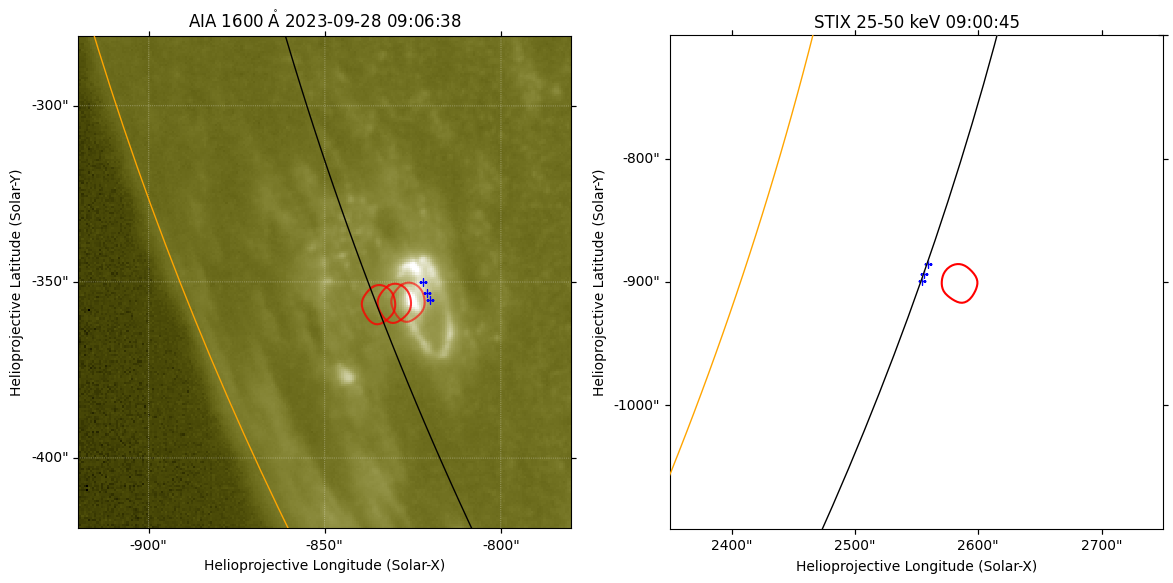

In [7]:
aia_map=aia_maps[1]
stix_map=stix_maps[0]

base_points=[SkyCoord(Tx=-822*u.arcsec,Ty=-350*u.arcsec, frame=aia_map.coordinate_frame),
             SkyCoord(Tx=-821*u.arcsec,Ty=-353*u.arcsec, frame=aia_map.coordinate_frame),
             SkyCoord(Tx=-820*u.arcsec,Ty=-355*u.arcsec, frame=aia_map.coordinate_frame)]
pro_base_point=[Project_to_back(stix_map,bp) for bp in base_points]
#base_points,pro_base_point
linewidths=0.6
aia_color='orange'
stix_color='black'
base_color='blue'
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate,only_off_disk=True):

    fig=plt.figure(figsize=(14,7))
    plt.rc('font', size=10)

    ax1=fig.add_subplot(1,2,1,projection=aia_map)
    aia_map.plot(axes=ax1,norm=norm1600,cmap=cmap1600)
    aia_map.draw_limb(axes=ax1,color=aia_color,linestyle='solid')

    xarc = [-920,-780] * u.arcsec
    yarc = [-420,-280] * u.arcsec
    Set_wlim(ax1,aia_map,xarc,yarc)

    stix_map.draw_limb(axes=ax1,color=stix_color,linestyle='solid')

    for bp in base_points:
        ax1.plot_coord(bp,'+',color=base_color)


    ax2=fig.add_subplot(1,2,2,projection=blank_map)
    blank_map.plot(axes=ax2,cmap='Greys')
    blank_map.draw_limb(axes=ax2)
    ax2.set_title('STIX 25-50 keV '+blank_map.meta['date-avg'][11:19])
    stix_map.draw_limb(axes=ax2,color=stix_color)
    aia_map.draw_limb(axes=ax2,color=aia_color,linestyle='solid')

    xarc = [2350,2750] * u.arcsec
    yarc = [-1100,-700] * u.arcsec
    Set_wlim(ax2,blank_map,xarc,yarc)

    maxv=stix_map.data.max()
    levels=[0.5*maxv]
    stix_map.draw_contours(axes=ax2,levels=levels,colors='red')

    for bp in pro_base_point:
        ax2.plot_coord(bp,'+',color=base_color)

    rsun_arc=stix_map.meta['rsun_arc']
    rsun_ref=stix_map.meta['rsun_ref']
    maxv=stix_map.data.max()
    levels=[0.5*maxv]
    cont_coord_list=[stix_map.contour(l)for l in levels]
    coord_frame=aia_map.coordinate_frame
    color='red'

    for cont_coord in cont_coord_list:
        for cc in cont_coord:
            cc_list=[SkyCoord(cc.Tx[i],cc.Ty[i],frame=cc.frame) for i in range(len(cc.Tx))]
            hts=[Get_ht(cl,pro_base_point,rsun_arc,rsun_ref) for cl in cc_list]

            cc_list_upd=[update_ht_in_coord(cl,ht+0.18) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.8)
            
            cc_list_upd=[update_ht_in_coord(cl,ht+0.3) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.8)

            cc_list_upd=[update_ht_in_coord(cl,ht+0.5) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.6)

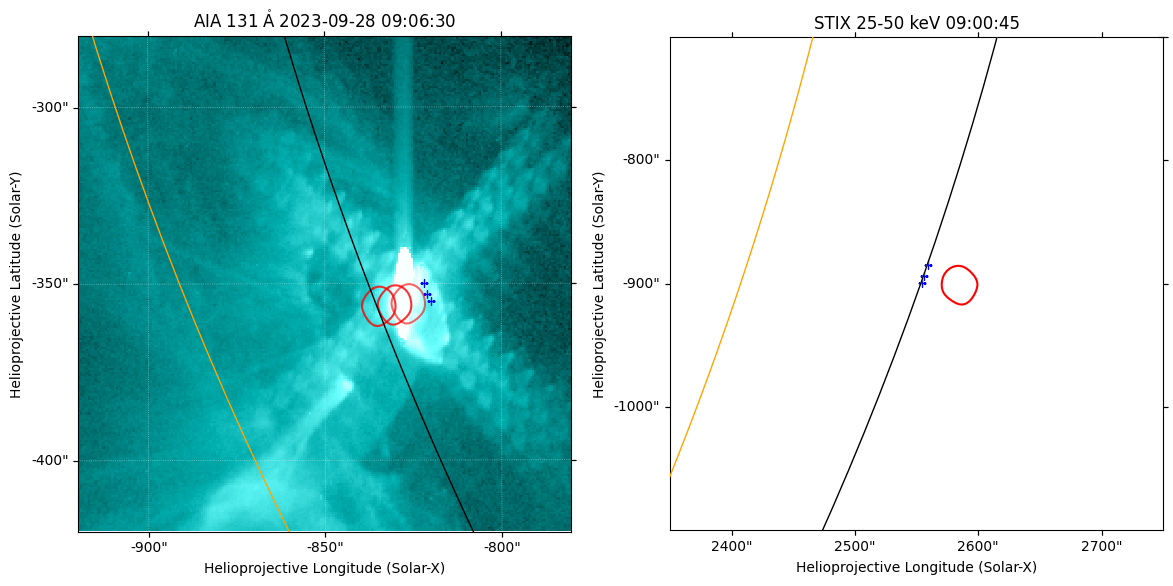

In [8]:
aia_map=aia_maps[0]
stix_map=stix_maps[0]

base_points=[SkyCoord(Tx=-822*u.arcsec,Ty=-350*u.arcsec, frame=aia_map.coordinate_frame),
             SkyCoord(Tx=-821*u.arcsec,Ty=-353*u.arcsec, frame=aia_map.coordinate_frame),
             SkyCoord(Tx=-820*u.arcsec,Ty=-355*u.arcsec, frame=aia_map.coordinate_frame)]
pro_base_point=[Project_to_back(stix_map,bp) for bp in base_points]
#base_points,pro_base_point
linewidths=0.6
aia_color='orange'
stix_color='black'
base_color='blue'
with Helioprojective.assume_spherical_screen(aia_map.observer_coordinate,only_off_disk=True):

    fig=plt.figure(figsize=(14,7))
    plt.rc('font', size=10)

    ax1=fig.add_subplot(1,2,1,projection=aia_map)
    aia_map.plot(axes=ax1,norm=norm131,cmap=cmap131)
    aia_map.draw_limb(axes=ax1,color=aia_color,linestyle='solid')

    xarc = [-920,-780] * u.arcsec
    yarc = [-420,-280] * u.arcsec
    Set_wlim(ax1,aia_map,xarc,yarc)

    stix_map.draw_limb(axes=ax1,color=stix_color,linestyle='solid')

    for bp in base_points:
        ax1.plot_coord(bp,'+',color=base_color)


    ax2=fig.add_subplot(1,2,2,projection=blank_map)
    blank_map.plot(axes=ax2,cmap='Greys')
    blank_map.draw_limb(axes=ax2)
    ax2.set_title('STIX 25-50 keV '+blank_map.meta['date-avg'][11:19])
    stix_map.draw_limb(axes=ax2,color=stix_color)
    aia_map.draw_limb(axes=ax2,color=aia_color,linestyle='solid')

    xarc = [2350,2750] * u.arcsec
    yarc = [-1100,-700] * u.arcsec
    Set_wlim(ax2,blank_map,xarc,yarc)

    maxv=stix_map.data.max()
    levels=[0.5*maxv]
    stix_map.draw_contours(axes=ax2,levels=levels,colors='red')

    for bp in pro_base_point:
        ax2.plot_coord(bp,'+',color=base_color)

    rsun_arc=stix_map.meta['rsun_arc']
    rsun_ref=stix_map.meta['rsun_ref']
    maxv=stix_map.data.max()
    levels=[0.5*maxv]
    cont_coord_list=[stix_map.contour(l)for l in levels]
    coord_frame=aia_map.coordinate_frame
    color='red'

    for cont_coord in cont_coord_list:
        for cc in cont_coord:
            cc_list=[SkyCoord(cc.Tx[i],cc.Ty[i],frame=cc.frame) for i in range(len(cc.Tx))]
            hts=[Get_ht(cl,pro_base_point,rsun_arc,rsun_ref) for cl in cc_list]

            cc_list_upd=[update_ht_in_coord(cl,ht+0.18) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.8)
            
            cc_list_upd=[update_ht_in_coord(cl,ht+0.3) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.8)

            cc_list_upd=[update_ht_in_coord(cl,ht+0.5) for cl,ht in zip(cc_list,hts)]
            transformed_coord=Transform_coord_to_one_map(cc_list_upd,coord_frame)
            ax1.plot_coord(transformed_coord,'-',color=color,alpha=0.6)